In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve)
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tqdm.keras import TqdmCallback
tf.random.set_seed(42)
print(tf.__version__)

2.14.0


In [3]:
seed = 1
accuracy = 'average_precision'
lr_max_iterations = 10000

In [4]:
df = pd.read_csv("creditcard.csv")
assert(df.shape[0] == 284807)
assert(df.shape[1] == 31)

In [5]:
X_orig = df.drop('Class', axis=1) 
y_orig = df.Class 
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2,
                                                    random_state=seed, stratify=y_orig)
test_data = [X_test, y_test]
print(f"Training data class counts:\n{y_train.value_counts()}")
print('')
print(f"Test data class counts:\n{y_test.value_counts()}")
print('')
assert(y_test.shape[0]/y_orig.shape[0] > 0.19)

Training data class counts:
0    227451
1       394
Name: Class, dtype: int64

Test data class counts:
0    56864
1       98
Name: Class, dtype: int64



In [6]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_data_scaled = [X_test_scaled, y_test]

In [7]:
oversampler = SMOTE(random_state=2)
X_train_res, y_train_res = oversampler.fit_resample(X_train, y_train)

In [8]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (454902, 30)
After OverSampling, the shape of train_y: (454902,) 

After OverSampling, counts of label '1': 227451
After OverSampling, counts of label '0': 227451


In [9]:
X_train_0 = X_train_res[y_train_res == 0]
X_train_AE = X_train_0.sample(frac=0.5, random_state=seed)
X_train_AE_scaled = StandardScaler().fit_transform(X_train_AE)

X_train_est = X_train_res.drop(X_train_AE.index)
y_train_est = y_train_res.drop(X_train_AE.index)

latent_scaler = StandardScaler()
X_train_est_scaled = latent_scaler.fit_transform(X_train_est)
X_test_est_scaled = latent_scaler.transform(X_test)

In [10]:
def create_autoencoder(input_dim=30, latent_dim=50):
    input_layer = Input(shape=(input_dim,), name='Input')
    encoded = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5), name='Encoding')(input_layer)
    latent =  Dense(latent_dim, activation='relu', name='Latent')(encoded)
    decoded = Dense(100, activation='relu', name='Decoding')(latent)
    output_layer = Dense(input_dim, activation='linear', name='Output')(decoded)
    
    autoencoder = Model(input_layer, output_layer)
    return autoencoder

In [11]:
autoencoder = create_autoencoder()
autoencoder.compile(optimizer="adadelta", loss="mse")
autoencoder.summary()
    
history = autoencoder.fit(X_train_AE_scaled, X_train_AE_scaled,
                          batch_size=64, epochs=500, verbose=0, validation_split=0.15,
                          callbacks=[TqdmCallback(), EarlyStopping(patience=3)])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30)]              0         
                                                                 
 Encoding (Dense)            (None, 100)               3100      
                                                                 
 Latent (Dense)              (None, 50)                5050      
                                                                 
 Decoding (Dense)            (None, 100)               5100      
                                                                 
 Output (Dense)              (None, 30)                3030      
                                                                 
Total params: 16280 (63.59 KB)
Trainable params: 16280 (63.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [12]:
def create_encoder(autoencoder):
    encoder = Sequential([autoencoder.layers[0],
                          autoencoder.layers[1],
                          autoencoder.layers[2]])
    return encoder

In [13]:
encoder = create_encoder(autoencoder)
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoding (Dense)            (None, 100)               3100      
                                                                 
 Latent (Dense)              (None, 50)                5050      
                                                                 
Total params: 8150 (31.84 KB)
Trainable params: 8150 (31.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
X_train_latent = encoder.predict(X_train_est_scaled)
X_test_latent = encoder.predict(X_test_est_scaled)
test_data_latent = [X_test_latent, y_test]

1781/1781 [==============================] - 1s 644us/step


In [15]:
import tensorflow as tf

# Adding layers in ANN
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(input_dim = 50, units=50, activation='relu'))
ann.add(tf.keras.layers.Dense(units=50, activation='relu'))
ann.add(tf.keras.layers.Dense(units=50, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print("Model training start........")
ann.fit(X_train_latent, y_train_est, batch_size = 15, epochs = 5)

Model training start........
Epoch 1/5
22746/22746 [==============================] - 26s 1ms/step - loss: 0.0601 - accuracy: 0.9772
Epoch 2/5
22746/22746 [==============================] - 26s 1ms/step - loss: 0.0282 - accuracy: 0.9899
Epoch 3/5
22746/22746 [==============================] - 28s 1ms/step - loss: 0.0201 - accuracy: 0.9932
Epoch 4/5
22746/22746 [==============================] - 26s 1ms/step - loss: 0.0166 - accuracy: 0.9945
Epoch 5/5
22746/22746 [==============================] - 28s 1ms/step - loss: 0.0140 - accuracy: 0.9955


1781/1781 [==============================] - 1s 723us/step


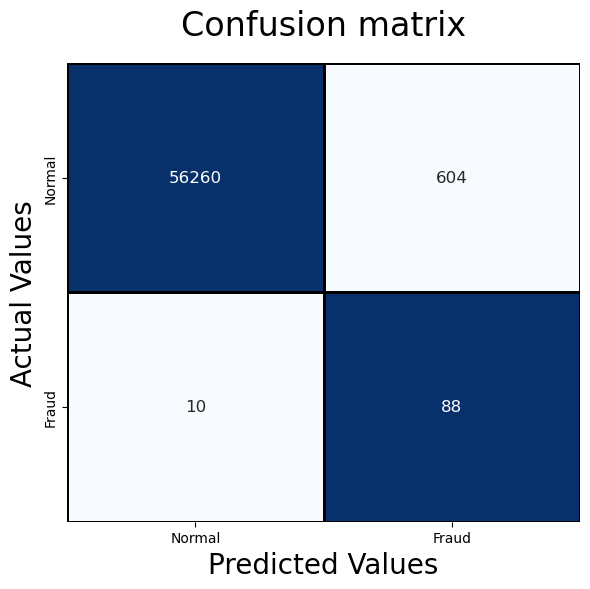

Classified 	88 out of 98 	fraud cases correctly
Misclassified 	604 out of 56864 normal cases
AROC score :- 
 0.9436686745604264


In [16]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.1)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")

1781/1781 [==============================] - 1s 762us/step


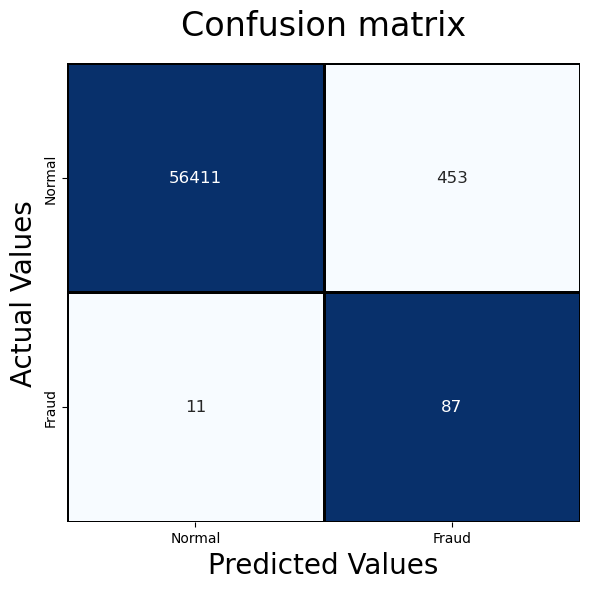

Classified 	87 out of 98 	fraud cases correctly
Misclassified 	453 out of 56864 normal cases
AROC score :- 
 0.9398943630631769


In [17]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.2)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")

1781/1781 [==============================] - 1s 798us/step


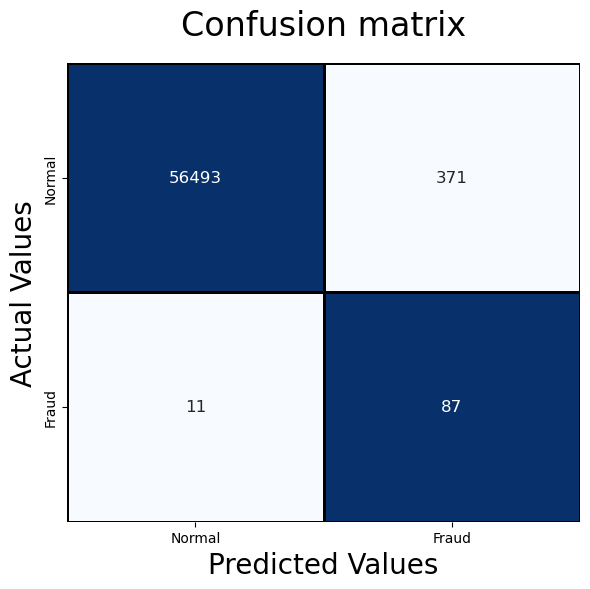

Classified 	87 out of 98 	fraud cases correctly
Misclassified 	371 out of 56864 normal cases
AROC score :- 
 0.9406153816338015


In [18]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.3)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")

1781/1781 [==============================] - 1s 727us/step


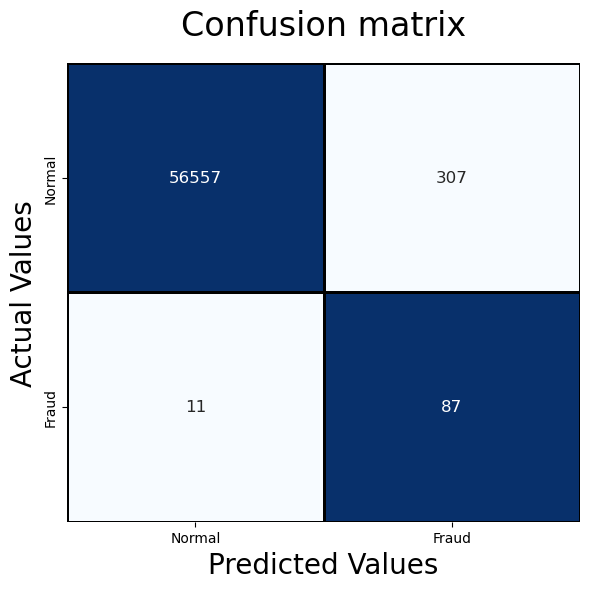

Classified 	87 out of 98 	fraud cases correctly
Misclassified 	307 out of 56864 normal cases
AROC score :- 
 0.9411781278352647


In [19]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.4)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")

1781/1781 [==============================] - 1s 747us/step


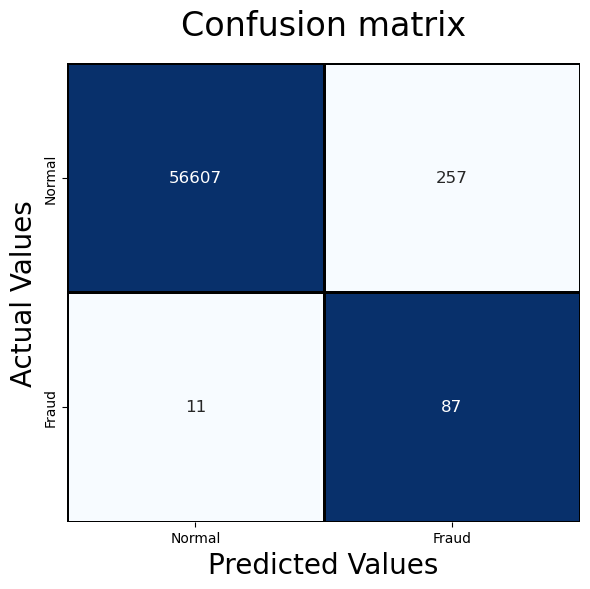

Classified 	87 out of 98 	fraud cases correctly
Misclassified 	257 out of 56864 normal cases
AROC score :- 
 0.9416177733051577


In [20]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.5)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")

1781/1781 [==============================] - 1s 733us/step


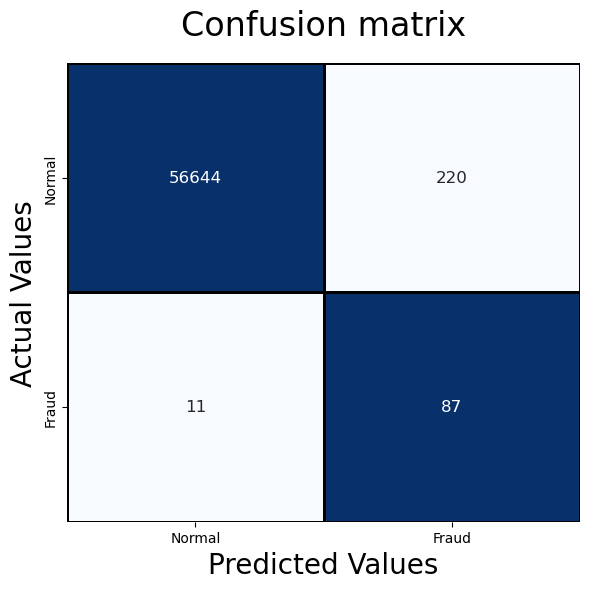

Classified 	87 out of 98 	fraud cases correctly
Misclassified 	220 out of 56864 normal cases
AROC score :- 
 0.9419431109528786


In [21]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.6)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")

1781/1781 [==============================] - 1s 754us/step


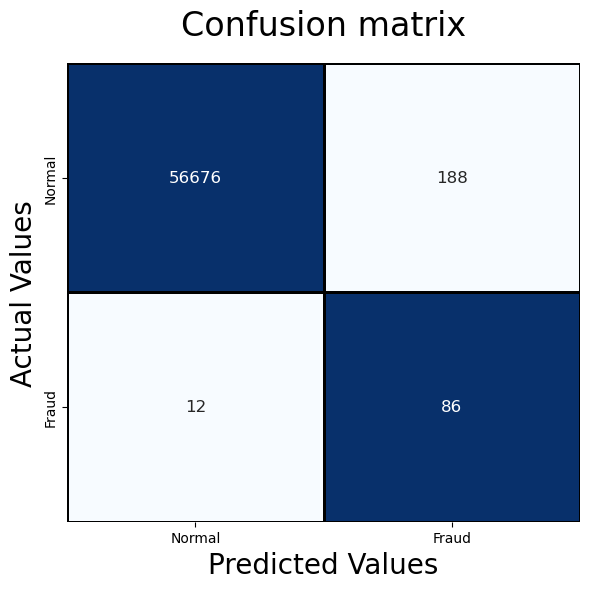

Classified 	86 out of 98 	fraud cases correctly
Misclassified 	188 out of 56864 normal cases
AROC score :- 
 0.9371224432372836


In [22]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.7)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")

1781/1781 [==============================] - 1s 751us/step


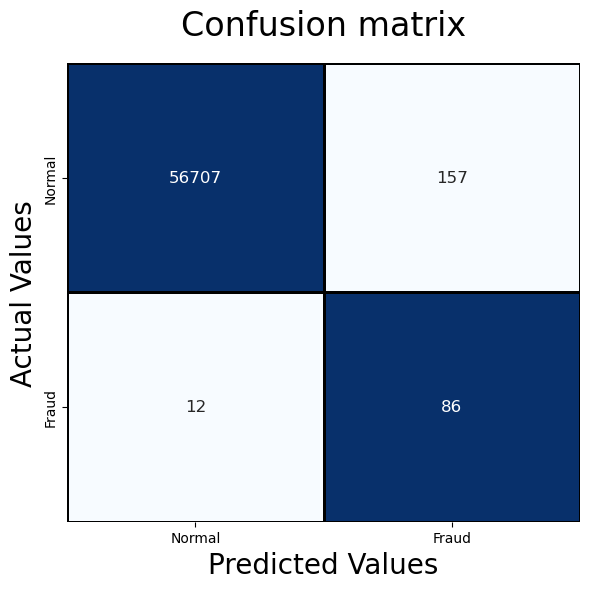

Classified 	86 out of 98 	fraud cases correctly
Misclassified 	157 out of 56864 normal cases
AROC score :- 
 0.9373950234286174


In [23]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.8)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")

1781/1781 [==============================] - 3s 1ms/step


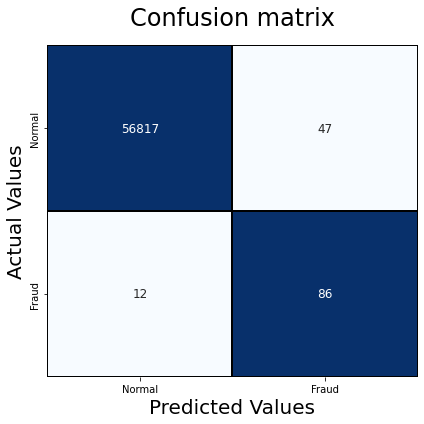

Classified 	86 out of 98 	fraud cases correctly
Misclassified 	47 out of 56864 normal cases
AROC score :- 
 0.9383622434623821


In [48]:
y_pred3 = ann.predict(X_test_latent)
y_pred3 = (y_pred3 >= 0.9)
LABELS = ['Normal', 'Fraud']
num_fraud_cases_in_test = len(y_test[y_test==1])
num_normal_cases_in_test = len(y_test[y_test==0])
cm = confusion_matrix(y_test, y_pred3)
fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 12},
            cmap='Blues', cbar=False,
            yticklabels=['Normal', 'Fraud'], xticklabels=['Normal', 'Fraud'], ax=ax,linewidths=2,linecolor = 'black')
ax.set_title('Confusion matrix', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)
plt.tight_layout()
plt.show()
print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
print(f"AROC score :- \n {roc_auc_score(y_test, y_pred3)}")